In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [ ]:
!gdown --id 11jHTacIQ2e3ndLseet-YQp3clAGWTpCu #ratings.csv
!gdown --id 1D1cO0G4WEUa6AAOrEHBgExjPZ5DSNn1a #credits.csv
!gdown --id 1FYYQsZYalPT3KItdbj4A29jj3setD-G9 #keywords.csv
!gdown --id 1Y7mZX40bA3dGLCsUem9Ayeooyx9TnFUp #movies-metadata.csv
!gdown --id 1mwNCe4qZoPvE_ktbHrvMNQ4hFovDsL3w #ratings_small.csv

Downloading...
From: https://drive.google.com/uc?id=11jHTacIQ2e3ndLseet-YQp3clAGWTpCu
To: /content/ratings.csv
710MB [00:06, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D1cO0G4WEUa6AAOrEHBgExjPZ5DSNn1a
To: /content/credits.csv
190MB [00:01, 133MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1FYYQsZYalPT3KItdbj4A29jj3setD-G9
To: /content/keywords.csv
6.23MB [00:00, 95.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y7mZX40bA3dGLCsUem9Ayeooyx9TnFUp
To: /content/movies_metadata.csv
34.4MB [00:00, 109MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mwNCe4qZoPvE_ktbHrvMNQ4hFovDsL3w
To: /content/ratings_small.csv
2.44MB [00:00, 76.5MB/s]


In [ ]:
df_credits = pd.read_csv("/content/credits.csv")
df_keywords = pd.read_csv("/content/keywords.csv")
df_movies = pd.read_csv("/content/movies_metadata.csv")
df_ratings = pd.concat([pd.read_csv("/content/ratings.csv"), pd.read_csv("/content/ratings_small.csv")])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Seth - Dataframe Merge (Without Ratings Merged)

#### Removing datetime values from movie id column in df_movies

In [ ]:
index = []

for i in range(0, len(df_movies['id'])):
  data = df_movies['id'].values[i]
  if (data.find('-') != -1):
    index.append(i)

In [ ]:
print(df_movies['id'][19730])
print(df_movies['id'][29503])
print(df_movies['id'][35587])

1997-08-20
2012-09-29
2014-01-01


In [ ]:
df_movies = df_movies.drop([19730, 29503, 35587])

In [ ]:
df_movies['id'] = pd.to_numeric(df_movies['id'])

#### Joining Credits and Keywords into df1

In [ ]:
df1 = df_credits.join(df_keywords.set_index('id'), on = 'id')

#### Joining Movies into df1

In [ ]:
df1 = df1.join(df_movies.set_index('id'), on = 'id')

# Merged DataFrame #1

In [ ]:
df1.head()

,cast,crew,id,keywords,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...",False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
df1.shape

(46628, 27)

In [ ]:
df1 = df1.drop_duplicates(['imdb_id'])

In [ ]:
df1.shape

(45416, 27)

# Exploratory Data Analysis (Chris)

#### Missing Data

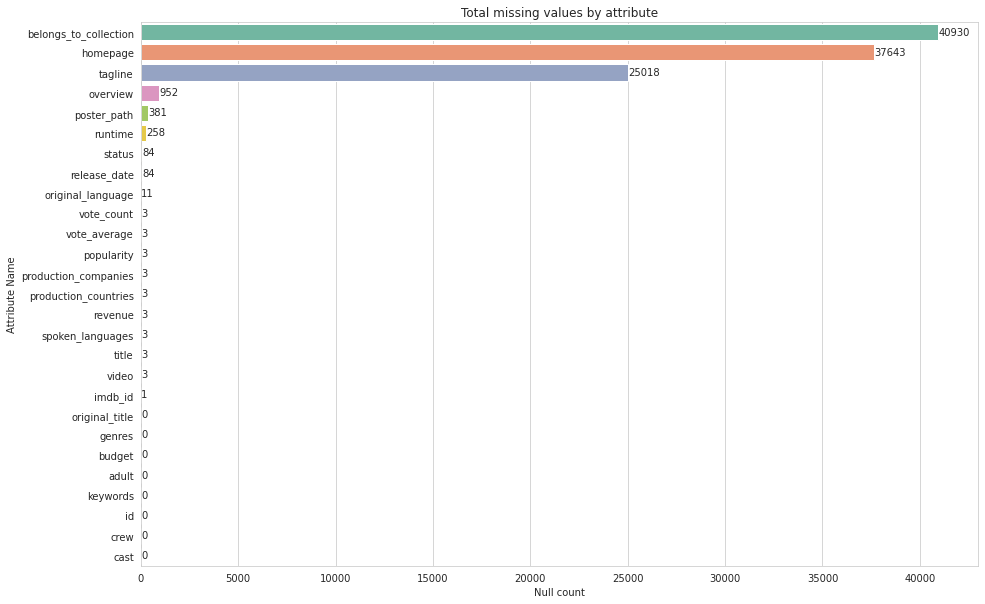

In [ ]:
total_missing = df1.isnull().sum().sort_values(ascending=False)
percent_missing = ((df1.isnull().sum() / df1.isnull().count()) * 100).sort_values(ascending=False)
missing_values = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
ax = sns.barplot(y=missing_values.index, x=missing_values['Total'], palette="Set2") 
ax.set_title('Total missing values by attribute')
ax.set_xlabel('Null count')
ax.set_ylabel('Attribute Name')

for p in ax.patches:
    plt.text(p.get_width()+12, p.get_y()+0.65*p.get_height(),
             '{:1.0f}'.format(p.get_width())) 

#### Movie Budget and Revenue by Year

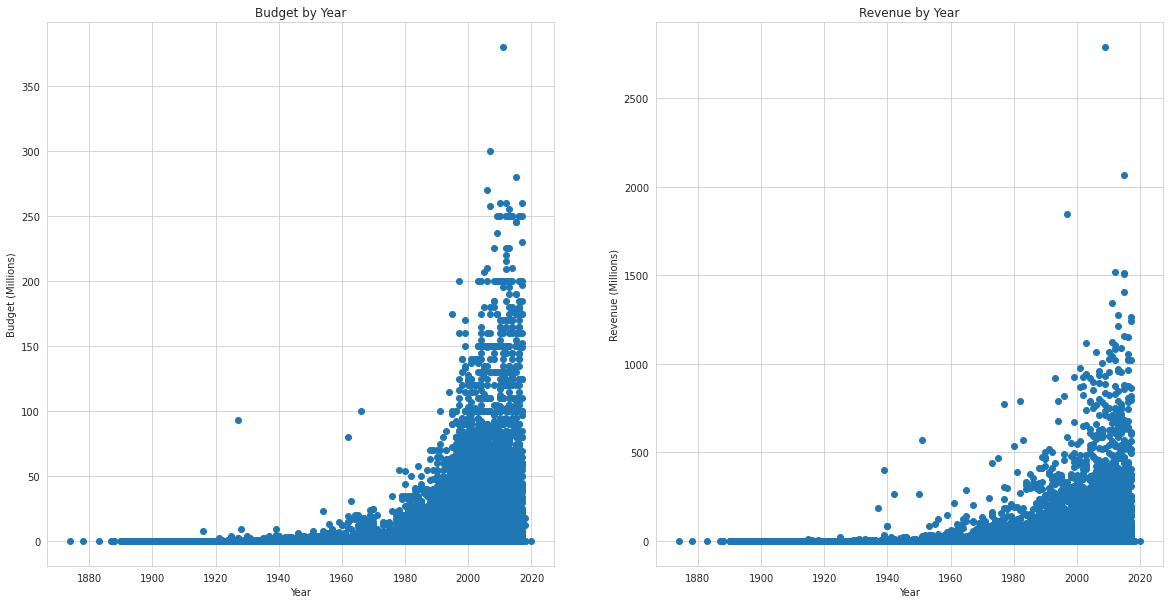

In [ ]:
dfBudget = df1[['release_date', 'budget', 'revenue']].dropna()
dfBudget['release_date'] = pd.DatetimeIndex(dfBudget['release_date']).year
dfBudget['budget'] = dfBudget['budget'].astype(str).astype(int)
dfBudget['budget'] = dfBudget['budget'].apply(lambda x: round(x/1000000))
dfBudget['revenue'] = dfBudget['revenue'].apply(lambda x: round(x/1000000))


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.scatter(x = 'release_date' ,y = 'budget' , data = dfBudget)
plt.xlabel("Year")
plt.ylabel("Budget (Millions)")
plt.title("Budget by Year")

plt.subplot(1, 2, 2)
plt.scatter(x = 'release_date' ,y = 'revenue' , data = dfBudget)
plt.xlabel("Year")
plt.ylabel("Revenue (Millions)")
plt.title("Revenue by Year")
plt.show()

#### AverageBudget/Revenue by Month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


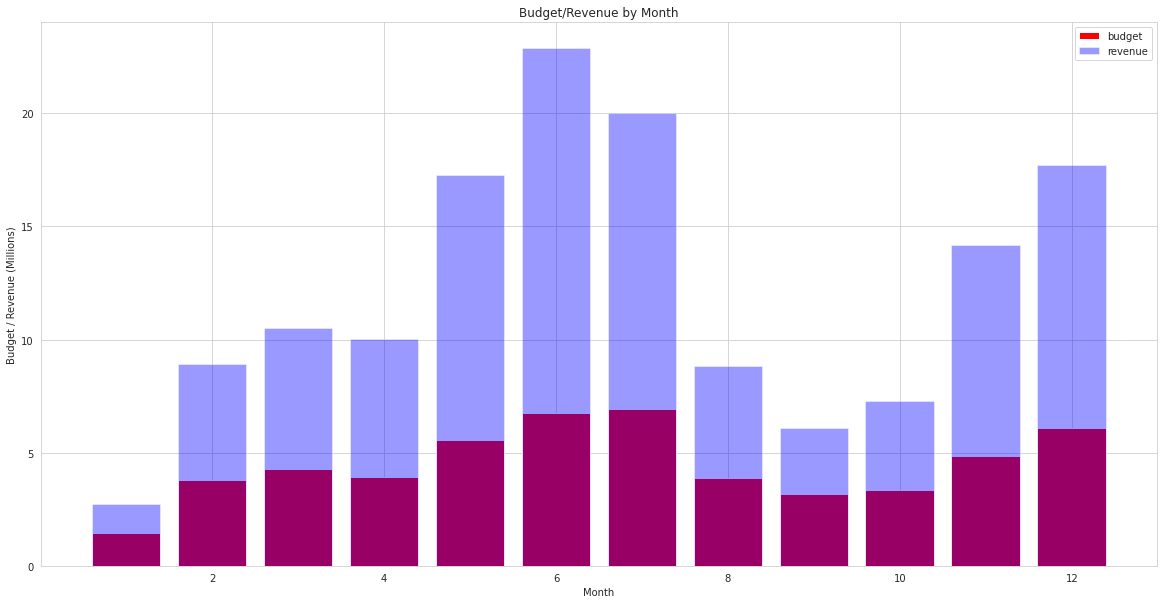

In [ ]:
dfBudget = df1[['release_date', 'budget', 'revenue']].dropna()
dfBudget['release_date'] = pd.DatetimeIndex(dfBudget['release_date']).month
dfBudget['budget'] = dfBudget['budget'].astype(str).astype(int)
dfBudget['budget'] = dfBudget['budget'].apply(lambda x: round(x/1000000))
dfBudget['revenue'] = dfBudget['revenue'].apply(lambda x: round(x/1000000))
dfBudget = dfBudget.groupby('release_date')['budget', 'revenue'].mean()

plt.figure(figsize=(20,10))
plt.bar(dfBudget.index , dfBudget['budget'], label='budget', color= 'r')
plt.bar(dfBudget.index , dfBudget['revenue'], label='revenue', alpha = 0.4, color= 'b')
plt.xlabel("Month")
plt.ylabel("Budget / Revenue (Millions)")
plt.title("Budget/Revenue by Month")
plt.legend(loc='best')
plt.show()


#### Top 20 Movies Profitability

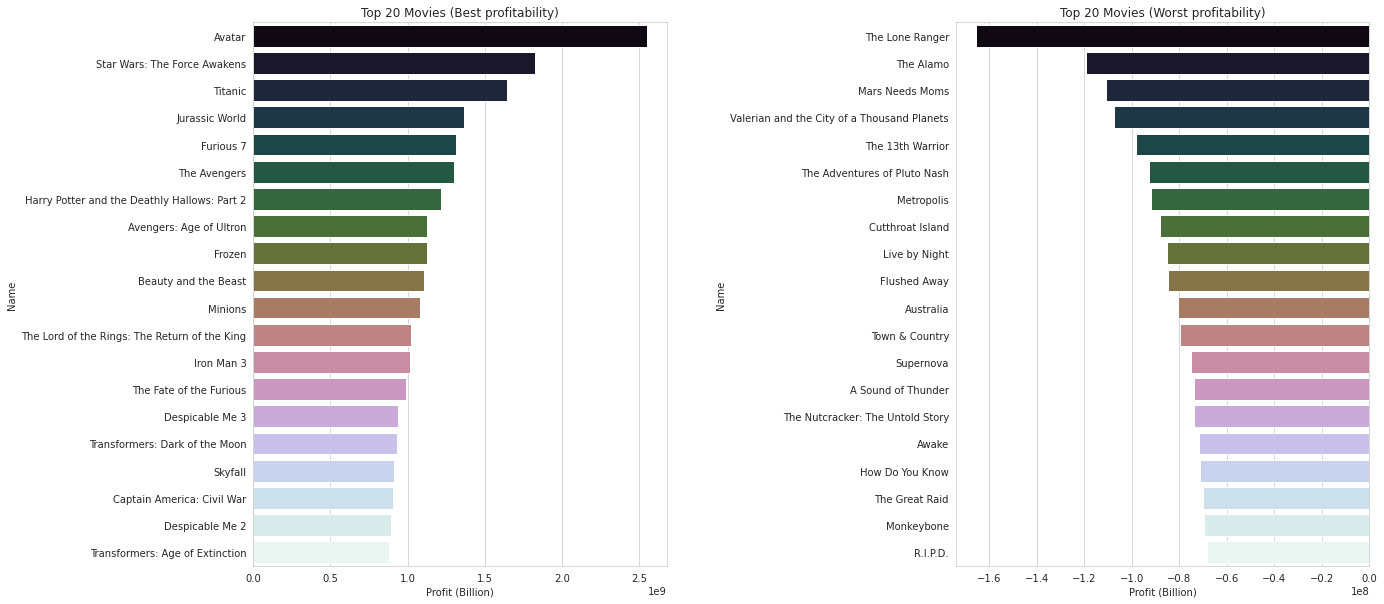

In [ ]:
dfProfit = df1[['original_title', 'budget', 'revenue']].dropna()
dfProfit['budget'] = dfProfit['budget'].astype(str).astype(int)
dfProfit['revenue'] = dfProfit['revenue'].astype(int)
#Remove rows where the budget or revenue is zero because they would not provide a fair comparison
dfProfit = dfProfit[dfProfit.revenue != 0]
dfProfit = dfProfit[dfProfit.budget != 0]
dfProfit['profit'] = dfProfit.apply(lambda row: int(row['revenue']) - row['budget'], axis=1)

plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
plt.subplot(1, 2, 1)
ax = sns.barplot(y='original_title', x='profit', data=dfProfit.sort_values('profit', ascending=False)[:20], palette="cubehelix") 
ax.set_title('Top 20 Movies (Best profitability)')
ax.set_xlabel("Profit (Billion)")
ax.set_ylabel('Name')

plt.subplot(1, 2, 2)
ax = sns.barplot(y='original_title', x='profit', data=dfProfit.sort_values('profit')[:20], palette="cubehelix") 
ax.set_title('Top 20 Movies (Worst profitability)')
ax.set_xlabel("Profit (Billion)")
ax.set_ylabel('Name')
plt.subplots_adjust(wspace=0.7)
plt.show()

#### Movies Per Year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of Movies')

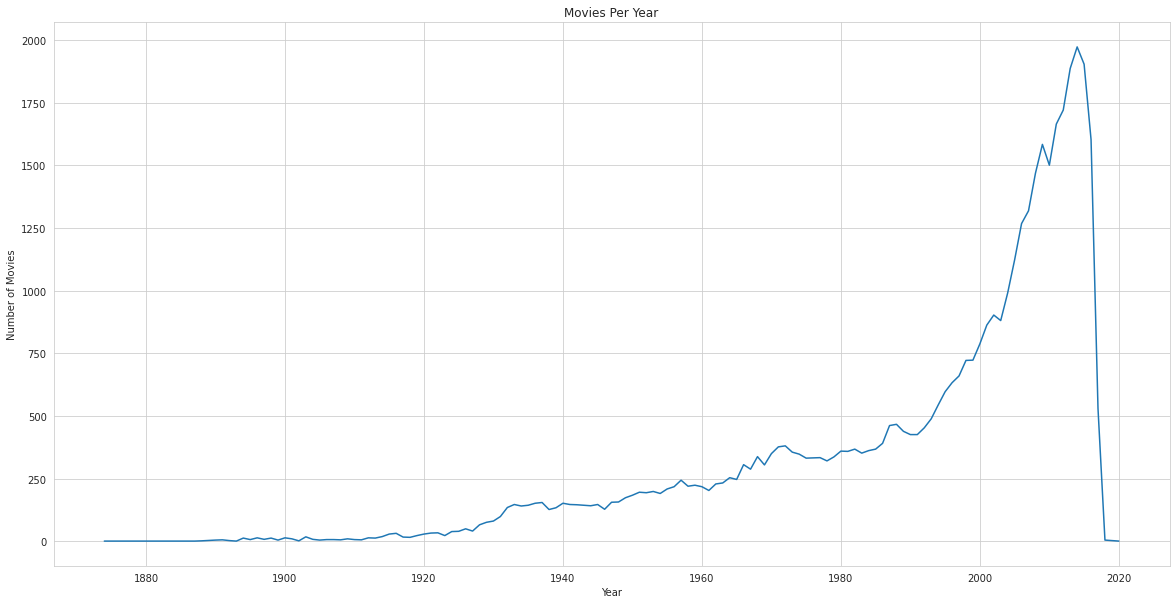

In [ ]:
dfYear = df1[['release_date']].dropna()
dfYear['release_date'] = pd.DatetimeIndex(dfYear['release_date']).year
dfdfBudget = dfBudget.groupby('release_date')['budget', 'revenue'].mean()
dfYear = dfYear.groupby('release_date')['release_date'].count().reset_index(name="count")

plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
ax = sns.lineplot(x='release_date', y='count', data=dfYear) 
ax.set_title('Movies Per Year')
ax.set_xlabel("Year")
ax.set_ylabel('Number of Movies')

#### Movies by Genre

In [ ]:
# Clean genres column
def clean_genre(row):
  genres = []
  gen_dict = eval(row)
  for i in range(len(gen_dict)):
    genres.append(gen_dict[i]['name'])

  return genres

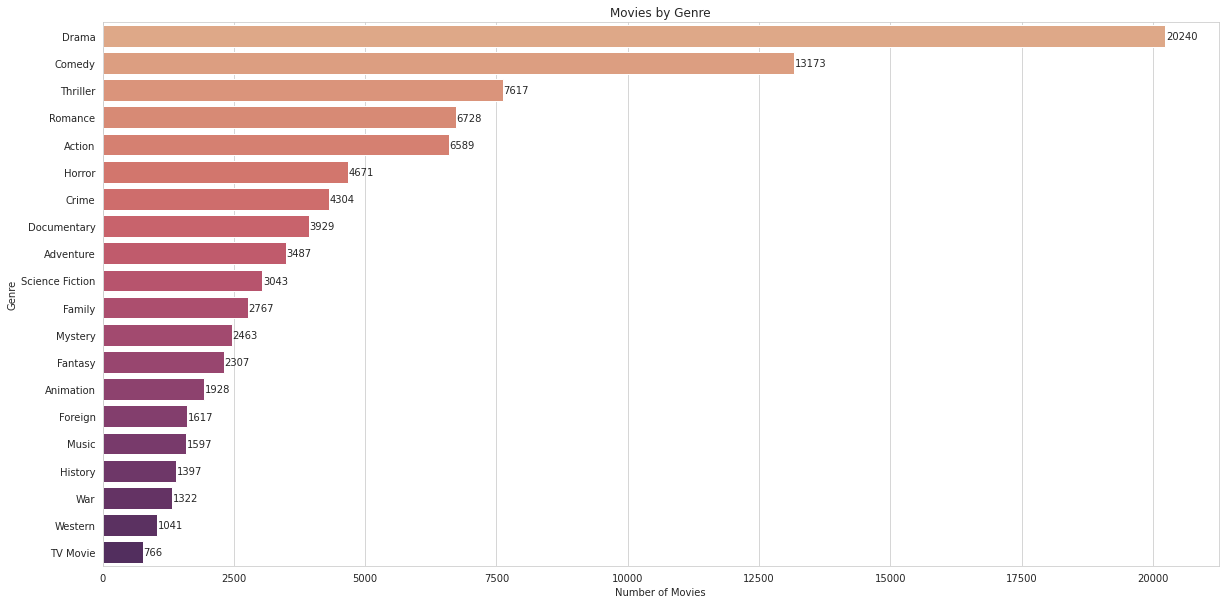

In [ ]:
df1['genres'] = df1['genres'].apply(lambda x: clean_genre(x))
dfGenres = df1[['genres']].dropna()
dfGenres = dfGenres[dfGenres['genres'].map(lambda x: len(x)) > 0]

dfGenres= pd.Series([x for item in dfGenres.genres for x in item]).value_counts().reset_index()
dfGenres.columns = ['genre', 'count']

plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
ax = sns.barplot(y='genre', x='count', data=dfGenres.sort_values('count', ascending=False), palette="flare") 
ax.set_title('Movies by Genre')
ax.set_xlabel("Number of Movies")
ax.set_ylabel('Genre')

for p in ax.patches:
    plt.text(p.get_width()+12, p.get_y()+0.65*p.get_height(),
             '{:1.0f}'.format(p.get_width())) 

#### Top 20 Actors

In [ ]:
# Clean cast column
def clean_cast(row):
  cast = []
  cast_dict = eval(row)
  for i in range(len(cast_dict)):
    cast.append(cast_dict[i]['name'])

  return cast

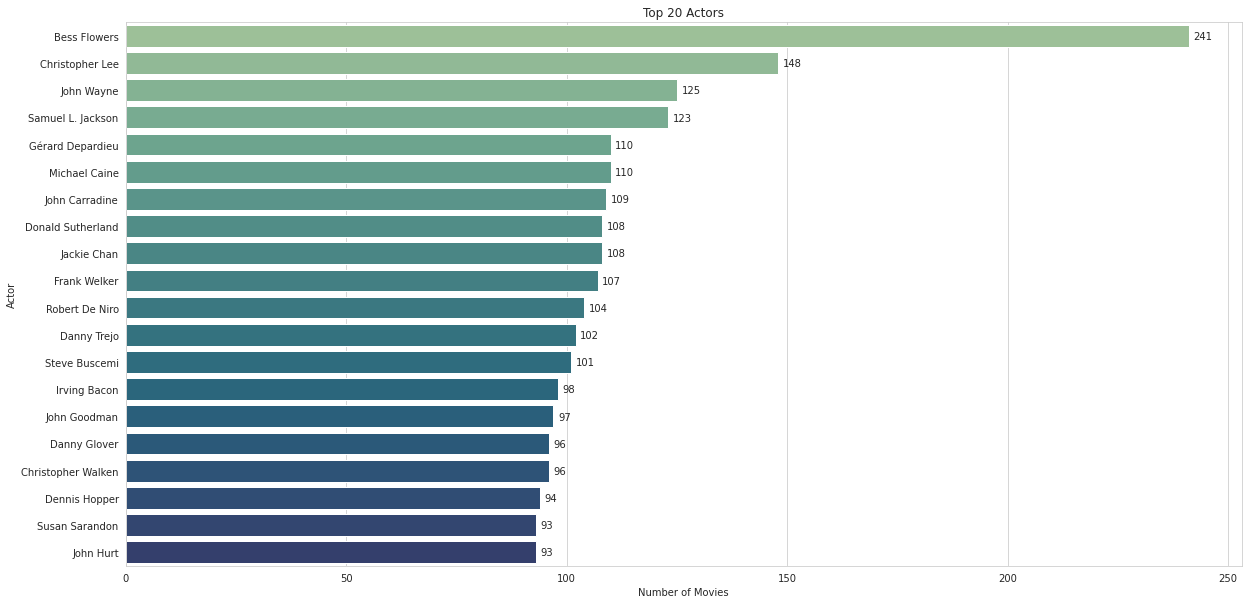

In [ ]:
df1['cast'] = df1['cast'].apply(lambda x: clean_cast(x))
dfCast = df1[['cast']].dropna()
dfCast = dfCast[dfCast['cast'].map(lambda x: len(x)) > 0]

dfCast= pd.Series([x for item in dfCast.cast for x in item]).value_counts().reset_index()
dfCast.columns = ['actor', 'count']

plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
ax = sns.barplot(y='actor', x='count', data=dfCast.sort_values('count', ascending=False)[:20], palette="crest") 
ax.set_title('Top 20 Actors')
ax.set_xlabel("Number of Movies")
ax.set_ylabel('Actor')

for p in ax.patches:
    plt.text(p.get_width()+1, p.get_y()+0.65*p.get_height(),
             '{:1.0f}'.format(p.get_width())) 

#### Movie Rating vs Popularity

Text(0, 0.5, 'Rating')

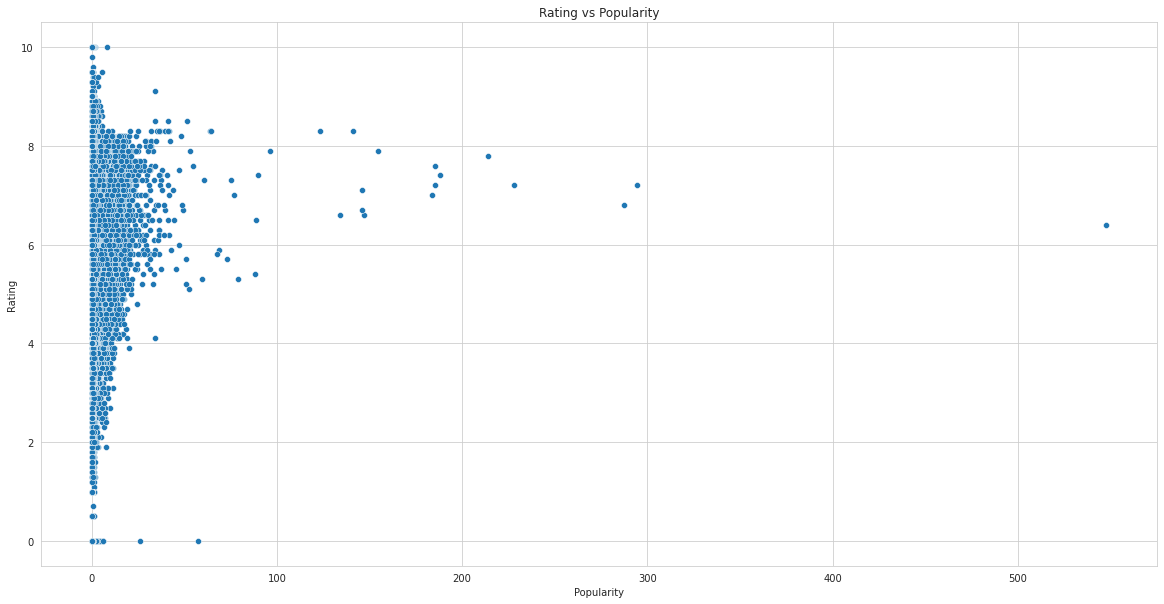

In [ ]:
dfPopRating = df1[['popularity', 'vote_average']].dropna()
dfPopRating['popularity'] = dfPopRating['popularity'].astype(float)
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = 'popularity' ,y = 'vote_average' , data = dfPopRating)
ax.set_title('Rating vs Popularity')
ax.set_xlabel("Popularity")
ax.set_ylabel("Rating")

#### Overview Word Cloud

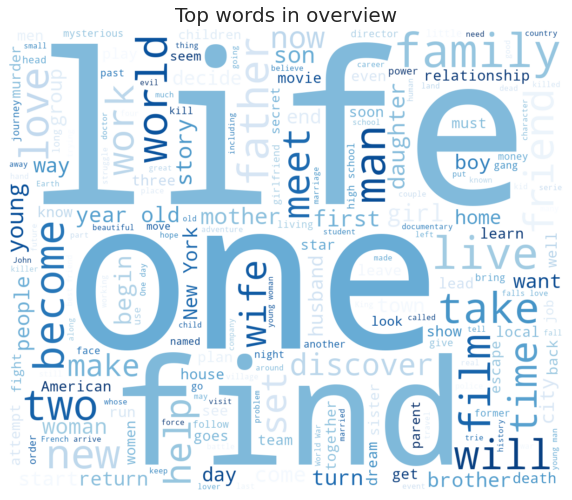

In [ ]:
dfOverView = df1[['overview']]
text = ' '.join(dfOverView['overview'].fillna('').values)
wordcloud = WordCloud(margin=10, background_color='white', colormap='Blues', width=1200, height=1000).generate(text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words in overview', fontsize=20)
plt.axis('off')
plt.show()

# Cleaning DF1

In [ ]:
del df1['crew']
del df1['homepage']
del df1['poster_path']
del df1['imdb_id']
del df1['overview']
del df1['tagline']
del df1['budget']
del df1['status']
del df1['video']
del df1['spoken_languages']
del df1['production_countries']
del df1['runtime']
del df1['original_title']
del df1['belongs_to_collection']
del df1['production_companies']

In [ ]:
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...",False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0


In [ ]:
df1.dtypes

cast                  object
id                     int64
keywords              object
adult                 object
genres                object
original_language     object
popularity            object
release_date          object
revenue              float64
title                 object
vote_average         float64
vote_count           float64
dtype: object

In [ ]:
# Clean keywords column
def clean_keywords(row):
  keywords = []
  keyword_dict = eval(row)
  for i in range(len(keyword_dict)):
    keywords.append(keyword_dict[i]['name'])

  return keywords

In [ ]:
df1['keywords'] = df1['keywords'].apply(lambda x: clean_keywords(x))

In [ ]:
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,"[jealousy, toy, boy, friendship, friends, riva...",False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,"[board game, disappearance, based on children'...",False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,"[fishing, best friend, duringcreditsstinger, o...",False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,"[based on novel, interracial relationship, sin...",False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,"[baby, midlife crisis, confidence, aging, daug...",False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0


### Creating a Cast DF

In [ ]:
cast = eval (df_credits['cast'].values[0])

In [ ]:
cast[0]['id']

31

In [ ]:
ids = []
actors = []

for i in range(0, len(df_credits['cast'])):
  castData = eval(df_credits['cast'].values[i])
  for j in range(len(castData)):
    ids.append(castData[j]['id'])
    actors.append(castData[j]['name'])

In [ ]:
castDF = pd.DataFrame({'id': ids, 'name': actors})

In [ ]:
castDF.head()

,id,name
0,31,Tom Hanks
1,12898,Tim Allen
2,7167,Don Rickles
3,12899,Jim Varney
4,12900,Wallace Shawn


In [ ]:
castDF[castDF.duplicated()]

,id,name
76,34,Mykelti Williamson
83,352,Dennis Haysbert
267,6280,Powers Boothe
269,382,Bob Hoskins
271,19839,David Paymer
...,...,...
562467,37822,Peter Dobson
562469,544742,Iwan Mosschuchin
562470,1090923,Nathalie Lissenko
562471,1136422,Pavel Pavlov


In [ ]:
castDF.shape

(562474, 2)

Remove Duplicates

In [ ]:
castDF.drop_duplicates(keep = 'first', inplace = True)

In [ ]:
castDF.shape

(206172, 2)

## Finding unique cast number for each movie

In [ ]:
# convert castDF into dictionary
castDict = dict(zip(castDF.name, castDF.id))

In [ ]:
castDict

{'Tom Hanks': 31,
 'Tim Allen': 12898,
 'Don Rickles': 7167,
 'Jim Varney': 12899,
 'Wallace Shawn': 12900,
 'John Ratzenberger': 7907,
 'Annie Potts': 8873,
 'John Morris': 1482679,
 'Erik von Detten': 12901,
 'Laurie Metcalf': 12133,
 'R. Lee Ermey': 8655,
 'Sarah Freeman': 12903,
 'Penn Jillette': 37221,
 'Robin Williams': 2157,
 'Jonathan Hyde': 8537,
 'Kirsten Dunst': 205,
 'Bradley Pierce': 145151,
 'Bonnie Hunt': 5149,
 'Bebe Neuwirth': 10739,
 'David Alan Grier': 58563,
 'Patricia Clarkson': 1276,
 'Adam Hann-Byrd': 46530,
 'Laura Bell Bundy': 56523,
 'James Handy': 51551,
 'Gillian Barber': 56522,
 'Brandon Obray': 1000304,
 'Cyrus Thiedeke': 188949,
 'Gary Joseph Thorup': 1076551,
 'Leonard Zola': 1480246,
 'Lloyd Berry': 25024,
 'Malcolm Stewart': 27110,
 'Annabel Kershaw': 53715,
 'Darryl Henriques': 1379424,
 'Robyn Driscoll': 1235504,
 'Peter Bryant': 25389,
 'Sarah Gilson': 1483449,
 'Florica Vlad': 1483450,
 'June Lion': 1483451,
 'Brenda Lockmuller': 1483452,
 'Walter 

In [ ]:
def get_cast_number(row):
  if len(row) == 0:
    return 0
  else:
    array = np.vectorize(castDict.get)(row)
    return sum(array)

In [ ]:
df1['castNum'] = df1['cast'].apply(lambda x: get_cast_number(x))

In [ ]:
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count,castNum
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,"[jealousy, toy, boy, friendship, friends, riva...",False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0,1629167
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,"[board game, disappearance, based on children'...",False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0,12868921
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,"[fishing, best friend, duringcreditsstinger, o...",False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0,64590
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,"[based on novel, interracial relationship, sin...",False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0,1467529
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,"[baby, midlife crisis, confidence, aging, daug...",False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0,1083159


## Find Genre Number for Each Movie

In [ ]:
def convert_genres(row):
  sum = 0
  for i in row:
    for j in i:
      sum+=ord(j)
  return sum

In [ ]:
df1['genreNum'] = df1['genres'].apply(lambda x: convert_genres(x))

In [ ]:
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count,castNum,genreNum
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,"[jealousy, toy, boy, friendship, friends, riva...",False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0,1629167,2147
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,"[board game, disappearance, based on children'...",False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0,12868921,2278
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,"[fishing, best friend, duringcreditsstinger, o...",False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0,64590,1318
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,"[based on novel, interracial relationship, sin...",False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0,1467529,1803
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,"[baby, midlife crisis, confidence, aging, daug...",False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0,1083159,609


## Convert Title to Number

In [ ]:
df1[df1['title'].apply(lambda x: isinstance(x, float))]

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count,castNum,genreNum
19729,"[Rob Lowe, Kenneth Cranham, Deborah Moore, Han...",82663,"[undercover, soldier]",False,"[Action, Thriller, Drama]",en,NaN,NaN,NaN,NaN,NaN,NaN,1306618,1929
29515,"[Megumi Hayashibara, Hiroki Touchi, Kazuya Nak...",122662,"[artificial intelligence, based on novel, cybe...",False,"[Animation, Science Fiction]",ja,NaN,NaN,NaN,NaN,NaN,NaN,947733,2374
35598,"[Alexander Mendeluk, Kate Nauta, Benjamin East...",249260,"[bikini, made for cable tv, curse, hot tub, sc...",False,"[TV Movie, Action, Horror, Science Fiction]",en,NaN,NaN,NaN,NaN,NaN,NaN,16931857,3402


Need to remove these columns since they have NaN values

In [ ]:
df1 = df1.drop([19729, 29515, 35598, 35598])

In [ ]:
def convert_titles(row):
  sum = 1;
  for i in row:
    sum+=ord(i)
  
  return(sum)

In [ ]:
# def convert_titles2(row):
#   return int.from_bytes(row.encode(), 'little')

In [ ]:
df1['titleNum'] = df1['title'].apply(lambda x: convert_titles(x))

In [ ]:
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count,castNum,genreNum,titleNum
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,"[jealousy, toy, boy, friendship, friends, riva...",False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0,1629167,2147,894
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,"[board game, disappearance, based on children'...",False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0,12868921,2278,719
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,"[fishing, best friend, duringcreditsstinger, o...",False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0,64590,1318,1483
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,"[based on novel, interracial relationship, sin...",False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0,1467529,1803,1614
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,"[baby, midlife crisis, confidence, aging, daug...",False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0,1083159,609,2336


In [ ]:
# copy
df_final = df1.copy()

In [ ]:
# df1 = df_final

## Chris - Clean & Transform the keywords column

#### Convert the array to string

In [ ]:
df1['keywords'] = df1['keywords'].apply(', '.join)
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count,castNum,genreNum,titleNum
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,"jealousy, toy, boy, friendship, friends, rival...",False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0,1629167,2147,894
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,"board game, disappearance, based on children's...",False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0,12868921,2278,719
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,"fishing, best friend, duringcreditsstinger, ol...",False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0,64590,1318,1483
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,"based on novel, interracial relationship, sing...",False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0,1467529,1803,1614
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,"baby, midlife crisis, confidence, aging, daugh...",False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0,1083159,609,2336


#### Convert to lowercast

In [ ]:
df1['keywords'] = df1['keywords'].str.lower()

#### Remove punctuations

In [ ]:
df1['keywords'] = df1['keywords'].str.replace('[^\w\s]','')

###### Remove links

In [ ]:
df1['keywords'] = df1['keywords'].str.replace('http\S+|www.\S+', '', case=False)

###### Remove html tags

In [ ]:
def rmtags(keyword):
  rmtag = re.compile('<.*?>')
  keywordtext = re.sub(rmtag, '', keyword)
  return keywordtext

df1['keywords'] = df1['keywords'].apply(lambda keyword: rmtags(keyword))

##### Remove additional whitespace

In [ ]:
df1['keywords'] = df1['keywords'].replace(' +', ' ', regex=True)
print(df1['keywords'][0])
print('\n----------\n')
print(df1['keywords'][1])

jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life

----------

board game disappearance based on childrens book new home recluse giant insect


### Encode the keywords with TFIDFVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(1,1))
tfidf = tfidf_vectorizer.fit_transform(df1['keywords'])

In [ ]:
keywordNum = np.sum(tfidf.A, axis=1)

In [ ]:
df1['keywords'] = keywordNum

In [ ]:
df1.head()

,cast,id,keywords,adult,genres,original_language,popularity,release_date,revenue,title,vote_average,vote_count,castNum,genreNum,titleNum
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,2.733326,False,"[Animation, Comedy, Family]",en,21.9469,1995-10-30,373554033.0,Toy Story,7.7,5415.0,1629167,2147,894
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,3.246428,False,"[Adventure, Fantasy, Family]",en,17.0155,1995-12-15,262797249.0,Jumanji,6.9,2413.0,12868921,2278,719
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,2.430422,False,"[Romance, Comedy]",en,11.7129,1995-12-22,0.0,Grumpier Old Men,6.5,92.0,64590,1318,1483
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,2.853171,False,"[Comedy, Drama, Romance]",en,3.85949,1995-12-22,81452156.0,Waiting to Exhale,6.1,34.0,1467529,1803,1614
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,3.213259,False,[Comedy],en,8.38752,1995-02-10,76578911.0,Father of the Bride Part II,5.7,173.0,1083159,609,2336


In [ ]:
title_df = df1['title']

In [ ]:
del df1['cast']
del df1['genres']
del df1['title']

In [ ]:
df1.head()

,id,keywords,adult,original_language,popularity,release_date,revenue,vote_average,vote_count,castNum,genreNum,titleNum
0,862,2.733326,False,en,21.9469,1995-10-30,373554033.0,7.7,5415.0,1629167,2147,894
1,8844,3.246428,False,en,17.0155,1995-12-15,262797249.0,6.9,2413.0,12868921,2278,719
2,15602,2.430422,False,en,11.7129,1995-12-22,0.0,6.5,92.0,64590,1318,1483
3,31357,2.853171,False,en,3.85949,1995-12-22,81452156.0,6.1,34.0,1467529,1803,1614
4,11862,3.213259,False,en,8.38752,1995-02-10,76578911.0,5.7,173.0,1083159,609,2336


### Convert remaining columns to numeric

In [ ]:
# change popularity to float
df1['popularity'] = df1['popularity'].apply(pd.to_numeric)

In [ ]:
# convert adult true or false to 1 or 0
adult_encoder = LabelEncoder()
df1["adult"] = adult_encoder.fit_transform(df1["adult"])

In [ ]:
# change date to date-time
df1['release_date'] = pd.to_datetime(df1['release_date'])

In [ ]:
categorical = df1.dtypes[df1.dtypes == "object"].index
categorical

Index(['original_language'], dtype='object')

In [ ]:
for c in categorical:
    df1[c] = df1[c].astype('category')
    df1[c] = df1[c].cat.codes

In [ ]:
df1.dtypes

id                            int64
keywords                    float64
adult                         int64
original_language              int8
popularity                  float64
release_date         datetime64[ns]
revenue                     float64
vote_average                float64
vote_count                  float64
castNum                       int64
genreNum                      int64
titleNum                      int64
dtype: object

In [ ]:
df2 = df1[['id', 'keywords', 'adult', 'original_language', 'popularity', 'revenue', 'vote_average', 'vote_count', 'castNum', 'genreNum', 'titleNum']]
df2['title'] = title_df.str.lower()

In [ ]:
df2.head(10)

,id,keywords,adult,original_language,popularity,revenue,vote_average,vote_count,castNum,genreNum,titleNum,title
0,862,2.733326,0,17,21.946943,373554033.0,7.7,5415.0,1629167,2147,894,toy story
1,8844,3.246428,0,17,17.015539,262797249.0,6.9,2413.0,12868921,2278,719,jumanji
2,15602,2.430422,0,17,11.712900,0.0,6.5,92.0,64590,1318,1483,grumpier old men
3,31357,2.853171,0,17,3.859495,81452156.0,6.1,34.0,1467529,1803,1614,waiting to exhale
4,11862,3.213259,0,17,8.387519,76578911.0,5.7,173.0,1083159,609,2336,father of the bride part ii
5,949,5.103419,0,17,17.924927,187436818.0,7.7,1886.0,22641097,2425,387,heat
6,11860,2.714283,0,17,6.677277,0.0,6.2,141.0,52994583,1318,705,sabrina
7,45325,0.000000,0,17,2.561161,0.0,5.4,45.0,398162,2643,1071,tom and huck
8,9091,2.218712,0,17,5.231580,64350171.0,5.5,174.0,132424,2386,1130,sudden death
9,710,4.929402,0,17,14.686036,352194034.0,6.6,1194.0,278410,2386,893,goldeneye


In [ ]:
df2.shape

(45413, 12)

In [ ]:
df2 = df2.drop_duplicates(['id'])
df2.head(10)

,id,keywords,adult,original_language,popularity,revenue,vote_average,vote_count,castNum,genreNum,titleNum,title
0,862,2.733326,0,17,21.946943,373554033.0,7.7,5415.0,1629167,2147,894,toy story
1,8844,3.246428,0,17,17.015539,262797249.0,6.9,2413.0,12868921,2278,719,jumanji
2,15602,2.430422,0,17,11.712900,0.0,6.5,92.0,64590,1318,1483,grumpier old men
3,31357,2.853171,0,17,3.859495,81452156.0,6.1,34.0,1467529,1803,1614,waiting to exhale
4,11862,3.213259,0,17,8.387519,76578911.0,5.7,173.0,1083159,609,2336,father of the bride part ii
5,949,5.103419,0,17,17.924927,187436818.0,7.7,1886.0,22641097,2425,387,heat
6,11860,2.714283,0,17,6.677277,0.0,6.2,141.0,52994583,1318,705,sabrina
7,45325,0.000000,0,17,2.561161,0.0,5.4,45.0,398162,2643,1071,tom and huck
8,9091,2.218712,0,17,5.231580,64350171.0,5.5,174.0,132424,2386,1130,sudden death
9,710,4.929402,0,17,14.686036,352194034.0,6.6,1194.0,278410,2386,893,goldeneye


In [ ]:
df2.shape

(45413, 12)

### Convert the Cleaned and Tranformed Dataframe to csv for use in the recommender system & Streamlit

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df2.to_csv('/content/drive/My Drive/Big Data Project/data/KaggleMovies.csv', index=False)